## Analyze Emission Lines

Using the fits to the emission lines from gmos_fit_data.py, this notebook creates:
1. `Halpha derived SFR and Balmer Decrement Map`
2. `NII BPT Diagram`
3. `Halpha NUV Ratio Map`
4. `Halpha CO Velocity Difference Map`
5. `Comparison to ALFOSC`

In [1]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [5]:
#system
from __future__ import division
import sys
import glob

#numpy
import numpy as np

import h5py

import pandas as pd

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set1_4 as brewermap
%matplotlib inline

#astropy
from astropy.wcs import WCS
import astropy.units as u
from astropy.io import fits
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Angle
import astropy.constants as const

#spectral fitting
import pyspeckit

#seaborn
import seaborn as sns 

import importlib


In [6]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject


In [7]:
#uncomment if need to reload module
importlib.reload(sf)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

In [8]:
#paths
fig_path = path_to_beads + 'Figures/paper/'
gmos_data_directory = path_to_beads + 'Analysis/gmosBeads/'

In [11]:
#About my galaxy cluster
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

angular_diameter_distance = cosmo.angular_diameter_distance(z=zh) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=zh).to(u.kpc / u.arcsec)

### Load Data

In [10]:
# Loading ppxf output for 1-Gaussian fit
save_path = ''.join((path_to_beads,'Analysis/gmosBeads/ppxf/fit_results/result_table/'))
# filename = save_path + 'sdss1531_ppxffit.hdf5'
filename = save_path + '2_ppxffit.hdf5'
f = h5py.File(filename, 'r')


In [12]:
#Load Field of View Cube
fov = gmos_data_directory + 'reduced/SDSSJ1531+3414.acube.fits'
hdu, hdr, w = pf.open_fits(fov, naxis=2)

In [13]:
#plot HST on top
hst_hdr, hst_wcs, hst_hdu = sf.load_HST_data(path_to_beads)
ysc_coords = sf.ysc_load(path_to_beads)
hst_cont_color, ysc_color = 'k', 'cyan'

hst_files = glob.glob(''.join((path_to_beads, '/Analysis/hst_data/h*')))

### 1. Halpha Derived SFR and Balmer Decrement


In [14]:
#Load Halpha flux map
Ha, Ha_err, Ha_mask = sf.ppxf_masked_flux_maps(f, 'Ha', err=True)


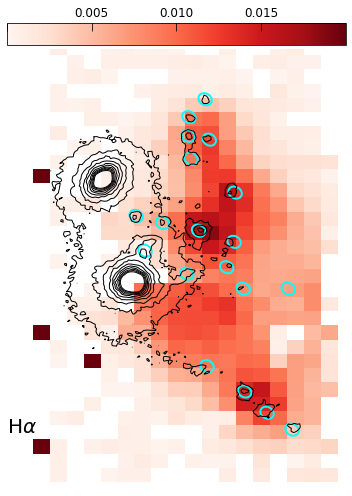

In [20]:
fig = plt.figure(figsize=(5, 7))
gs1 = GridSpec(1, 1)

clims=[[0, 0.02]]
cmap=cm.Reds
maps = [Ha]
map_names = [r'H$\alpha$']

for idm, map in enumerate(maps):

    clim = clims[idm]

    ax = fig.add_subplot(gs1[idm], projection=w)
    ax, cb = pf.ax_fits_map(hdu=None, data=map, hdr=hdr,
                            vmin=clim[0], vmax=clim[1], cmap=cmap, 
                            coords=None, ax=ax, contour=False, 
                            clip=None, lw=5, cbar=True, wcs=w)

    ##HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color=hst_cont_color, lw=1)

    #YSC Overlay
    pf.overlay(ax, None, 1, None, None, clusters=True, cont_color=ysc_color, 
                ysc_coords=ysc_coords)

    ax.set_xlim(20,0)
    ax.set_ylim(31, 0)

    ax.axis('off')
    ax.text(20, 27, map_names[idm], fontsize=20)

fig.tight_layout()


In [21]:
#mask very high values
masked_ha, masked_ha_err = np.array(Ha).copy(), np.array(Ha_err).copy()
mask = (Ha > 0.1)
masked_ha[mask] = np.nan
masked_ha_err[mask] = np.nan

The following kwargs were not used by contour: 'rasterized'


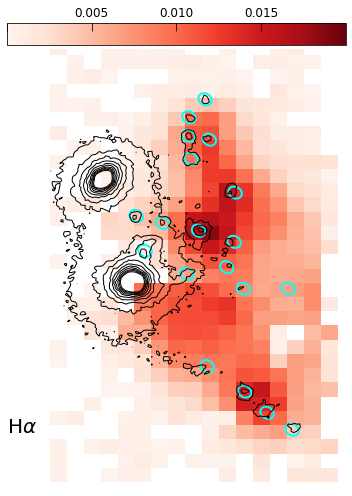

In [22]:
fig = plt.figure(figsize=(5, 7))
gs1 = GridSpec(1, 1)

clims=[[0, 0.02]]
cmap=cm.Reds
maps = [masked_ha]
map_names = [r'H$\alpha$']

for idm, map in enumerate(maps):

    clim = clims[idm]

    ax = fig.add_subplot(gs1[idm], projection=w)
    ax, cb = pf.ax_fits_map(hdu=None, data=map, hdr=hdr,
                            vmin=clim[0], vmax=clim[1], cmap=cmap, 
                            coords=None, ax=ax, contour=False, 
                            clip=None, lw=5, cbar=True, wcs=w)

    ##HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color=hst_cont_color, lw=1)

    #YSC Overlay
    pf.overlay(ax, None, 1, None, None, clusters=True, cont_color=ysc_color, 
                ysc_coords=ysc_coords)

    ax.set_xlim(20,0)
    ax.set_ylim(31, 0)

    ax.axis('off')
    ax.text(20, 27, map_names[idm], fontsize=20)

fig.tight_layout()


In [23]:
#convert Ha flux to SFR using Kennicutt-Schmidt relation

Ha_sfr = sf.sfr_ks(masked_ha * 10**-16 * u.Unit('erg cm-2 s-1') , z=0.335, cosmology=cosmo)
Ha_sfr_err = sf.sfr_ks(masked_ha_err * 10**-16 * u.Unit('erg cm-2 s-1') , z=0.335, cosmology=cosmo)

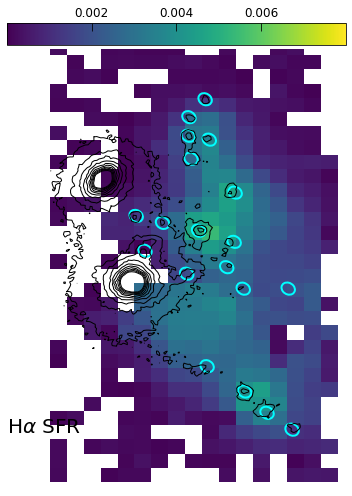

In [26]:
#plot sfr map

fig = plt.figure(figsize=(5, 7))
gs1 = GridSpec(1, 1)

clims=[[0, 0.008]]
cmap=cm.viridis
maps = [Ha_sfr]
map_names = [r'H$\alpha$ SFR']

for idm, map in enumerate(maps):

    clim = clims[idm]

    ax = fig.add_subplot(gs1[idm], projection=w)
    ax, cb = pf.ax_fits_map(hdu=None, data=map, hdr=hdr,
                            vmin=clim[0], vmax=clim[1], cmap=cmap, 
                            coords=None, ax=ax, contour=False, 
                            clip=None, lw=5, cbar=True, wcs=w)

    ##HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color=hst_cont_color, lw=1)

    #YSC Overlay
    pf.overlay(ax, None, 1, None, None, clusters=True, cont_color=ysc_color, 
                ysc_coords=ysc_coords)

    ax.set_xlim(20,0)
    ax.set_ylim(31, 0)

    ax.axis('off')
    ax.text(20, 27, map_names[idm], fontsize=20)

fig.tight_layout()


In [22]:
#Halpha derived SFR from SDSS DR10
flux_ha_dr10 = 63.35 * 10**-17 * u.Unit('erg cm-2 s-1')
sfr_dr10 = sf.sfr_ks(flux_ha_dr10, z=0.335, cosmology=cosmo)

print('SFR from SDSS DR10 Flux: {:.2f}'.format(sfr_dr10))

#Halpha derived SFR from SDSS DR18
flux_ha_dr18 = 87.60374 * 10**-17 * u.Unit('erg cm-2 s-1')
sfr_dr18 = sf.sfr_ks(flux_ha_dr18, z=0.335, cosmology=cosmo)

print('SFR from SDSS DR18 Flux: {:.2f}'.format(sfr_dr18))

#Halpha derived SFR from ALFOSC 2014
lum_ha_alfosc = 1.1e-15 * u.Unit('erg cm-2 s-1')
sfr_alfosc = sf.sfr_ks(lum_ha_alfosc, z=0.335, cosmology=cosmo)

print('SFR from ALFOSC Lum: {:.2f}'.format(sfr_alfosc))

SFR from SDSS DR10 Flux: 1.85 solMass / yr
SFR from SDSS DR18 Flux: 2.55 solMass / yr
SFR from ALFOSC Lum: 3.21 solMass / yr


Balmer Decrement

In [27]:
#Load Halpha and Hbeta maps
Ha, Ha_mask = sf.ppxf_masked_flux_maps(f, 'Ha')
Hb, Hb_mask = sf.ppxf_masked_flux_maps(f, 'Hb')

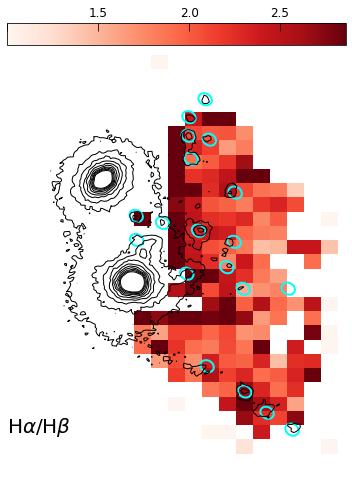

In [22]:
fig = plt.figure(figsize=(5, 7))
gs1 = GridSpec(1, 1)

clims=[[1, 2.86]]
cmap=cm.Reds
maps = [Ha/Hb]
map_names = [r'H$\alpha$/H$\beta$']

for idm, map in enumerate(maps):

    clim = clims[idm]

    ax = fig.add_subplot(gs1[idm], projection=w)
    ax, cb = pf.ax_fits_map(hdu=None, data=map, hdr=hdr,
                            vmin=clim[0], vmax=clim[1], cmap=cmap, 
                            coords=None, ax=ax, contour=False, 
                            clip=None, lw=5, cbar=True, wcs=w)

    ##HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color=hst_cont_color, lw=1)

    #YSC Overlay
    pf.overlay(ax, None, 1, None, None, clusters=True, cont_color=ysc_color, 
                ysc_coords=ysc_coords)

    ax.set_xlim(20,0)
    ax.set_ylim(31, 0)

    ax.axis('off')
    ax.text(20, 27, map_names[idm], fontsize=20)

fig.tight_layout()


The simple Ha/Hb ratio map is below the expected value. This will lead to an unphysical balmer decrement. Better data is needed to confirm whether this is an accurate description of the optical lines

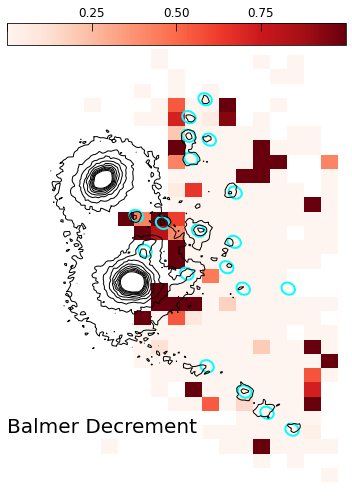

In [28]:
fig = plt.figure(figsize=(5, 7))
gs1 = GridSpec(1, 1)

clims=[[0, 1]]
cmap=cm.Reds
maps = [sf.av(Ha, Hb)]
map_names = ['Balmer Decrement']

for idm, map in enumerate(maps):

    clim = clims[idm]

    ax = fig.add_subplot(gs1[idm], projection=w)
    ax, cb = pf.ax_fits_map(hdu=None, data=map, hdr=hdr,
                            vmin=clim[0], vmax=clim[1], cmap=cmap, 
                            coords=None, ax=ax, contour=False, 
                            clip=None, lw=5, cbar=True, wcs=w)

    ##HST Contours: uncomment below lines if not in rush
    pf.overlay(ax, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color=hst_cont_color, lw=1)

    #YSC Overlay
    pf.overlay(ax, None, 1, None, None, clusters=True, cont_color=ysc_color, 
                ysc_coords=ysc_coords)

    ax.set_xlim(20,0)
    ax.set_ylim(31, 0)

    ax.axis('off')
    ax.text(20, 27, map_names[idm], fontsize=20)

fig.tight_layout()


most of the values are below zero! Unphysical!

### 2. [NII] BPT Diagram


In [37]:
def classify_nii_bpt_spaxels(table, snr_threshold=3):
    """
    Classify spaxels in the BPT diagram using the [NII] emission line.
    
    The BPT (Baldwin, Phillips, & Terlevich) diagram is a diagnostic tool to classify galaxies
    based on their emission line ratios. This function specifically focuses on classifying spaxels
    using the [NII] emission line in the BPT diagram. Various classification lines from different
    studies are used to differentiate between different excitation sources.
    
    Classification Lines:
    - Kewley et al. 2001: Starburst vs AGN (Active Galactic Nucleus) classification
    - Kauffmann et al. 2003: Starburst vs Composites classification
    - Schawinsky et al. 2007: Seyferts vs LINERS (Low-Ionization Nuclear Emission-line Region)
    
    The classification is performed based on the log flux ratios of [OIII]5006/Hbeta and 
    [NII]6583/Halpha emission lines.
    
    Returns:
    - log_flux_nii_ha: Logarithm of the flux ratio [NII]6583/Halpha
    - log_flux_oiii_hb: Logarithm of the flux ratio [OIII]5006/Hbeta
    - excitation: Excitation class of the spaxels (1: Star-Forming, 2: Composite, 
                  3: LINER, 4: AGN, NaN: Undetermined)
    """

    snr_ha, ha_mask = sf.ppxf_masked_flux_maps(table, 'Ha', snr=snr_threshold)
    snr_hb, hb_mask = sf.ppxf_masked_flux_maps(table, 'Hb', snr=snr_threshold)
    snr_oiii, oiii_mask = sf.ppxf_masked_flux_maps(table, 'OIII5007', snr=snr_threshold)
    snr_nii, nii_mask = sf.ppxf_masked_flux_maps(table, 'NII6583', snr=snr_threshold)

    log_flux_nii_ha = np.log10(snr_nii / snr_ha)
    log_flux_oiii_hb = np.log10(snr_oiii / snr_hb)

    kewley_nii = 0.61 / (log_flux_nii_ha - 0.47) + 1.19
    schaw_07 = 1.05 * log_flux_nii_ha + 0.45
    kauff_03 = 0.61 / (log_flux_nii_ha - 0.05) + 1.3
    
    agn_nii = ((log_flux_oiii_hb >= kewley_nii) & (log_flux_oiii_hb > schaw_07))
    liner_nii = ((log_flux_oiii_hb >= kewley_nii) & (log_flux_oiii_hb < schaw_07) | (log_flux_nii_ha >= 0.47))
    composite_nii = ((log_flux_oiii_hb >= kauff_03) & (log_flux_oiii_hb < kewley_nii))
    sf_nii = ((log_flux_oiii_hb < kauff_03) & (log_flux_nii_ha <= -0.25))

    excitation = np.zeros_like(snr_ha)
    excitation[sf_nii] = 1
    excitation[composite_nii] = 2
    excitation[liner_nii] = 3
    excitation[agn_nii] = 4
    excitation[excitation == 0.0] = np.nan

    return log_flux_nii_ha, log_flux_oiii_hb, excitation

In [38]:
nii_bpt = classify_nii_bpt_spaxels(f)

The following kwargs were not used by contour: 'rasterized'


(31.0, 0.0)

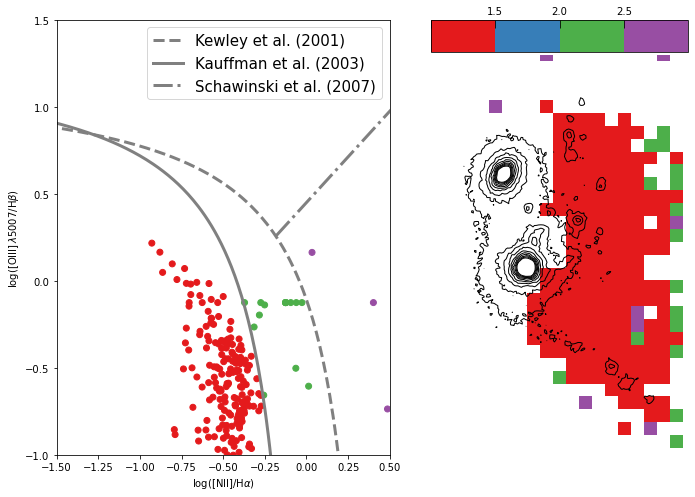

In [39]:
fig = plt.figure(figsize=(12, 8))
            
gs1 = GridSpec(1, 2)
gs1.update(wspace=0.01)

ax =  fig.add_subplot(gs1[0, 0])

cmap = ListedColormap(brewermap.mpl_colors)
excitation = nii_bpt[2]

ax.scatter(nii_bpt[0], nii_bpt[1], c=excitation, cmap=cmap)

t = np.arange(-2.0,0.3,0.01)
l = np.arange(-2.0,0.0,0.01)
s = np.arange(-0.18, 1.5, 0.01)

kewley_nii = 0.61/(t-0.47)+1.19
schaw_07 = 1.05*s+0.45
kauff_03 = 0.61/(l-0.05)+1.3

ax.plot(t,kewley_nii,'--',color='gray',linewidth=3,label='Kewley et al. (2001)')
ax.plot(l,kauff_03,'-',color='gray',linewidth=3,label='Kauffman et al. (2003)')
ax.plot(s,schaw_07,'-.',color='gray',linewidth=3,label='Schawinski et al. (2007)')


ax.set_xlim(-1.5, 0.5)
ax.set_ylim(-1, 1.5)
ax.legend(fontsize=15)
ax.set_ylabel(r'$\log(\mathrm{[O III]}\,\lambda 5007 / \mathrm{H}\beta)$')
ax.set_xlabel(r'$\log(\mathrm{[N II]}/ \mathrm{H}\alpha)$')


ax2 = fig.add_subplot(gs1[0, 1], projection=WCS(hdr), slices=('x', 'y', 0))
pf.ax_plot(ax2, excitation, hdr, cmap=cmap, vmin=None, vmax = None)
ax2.axis('off')
pf.overlay(ax2, hst_hdu, 1, vmin=0.05, vmax=0.5, nlev=10, contours=True, 
                cont_color='k', lw=1)
ax2.set_xlim(20,0)
ax2.set_ylim(31, 0)


### Halpha CO velocity Difference, dispersion ratio Map

In [22]:
Ha_flux, Ha_mask = sf.ppxf_masked_flux_maps(f, 'Ha', snr=3)
ha_vel_map, ha_fwhm_map = sf.ppxf_masked_vel_maps(f, Ha_mask)

dataset.value has been deprecated. Use dataset[()] instead.
dataset.value has been deprecated. Use dataset[()] instead.
dataset.value has been deprecated. Use dataset[()] instead.
dataset.value has been deprecated. Use dataset[()] instead.


In [23]:
#load alma
alma_path = ''.join((path_to_beads, 'Analysis/almaBeads/'))
vco32_file = ''.join((alma_path, 'reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor.fits'))
moment1_file = ''.join((vco32_file[:-5], '_M1.fits'))
moment2_file = ''.join((vco32_file[:-5] + '_M2.fits'))

moment1_hdu, moment1_hdr, m1wcs = pf.open_fits(moment1_file)
moment2_hdu, moment2_hdr, m2wcs = pf.open_fits(moment2_file)


alma_halpha_flux_map.fits


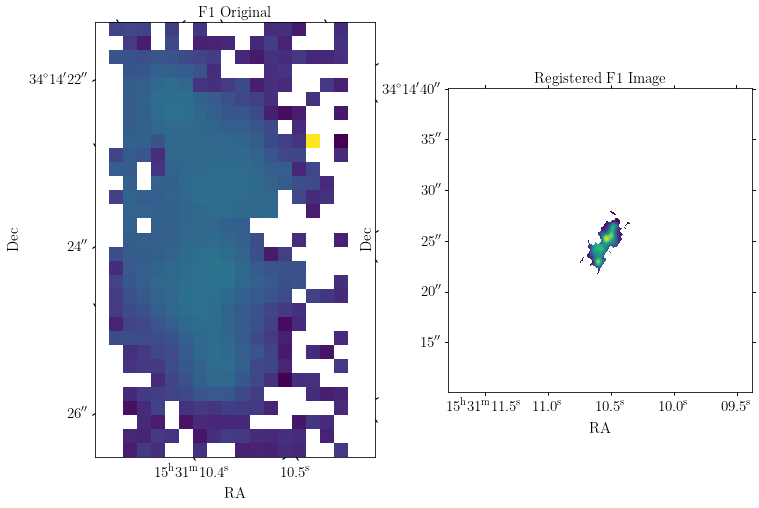

Successfully reprojected /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M1.fits to /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/gmosBeads/products/Halpha_flux_map.fits
saving new header to products folder
alma_halpha_vel_map.fits


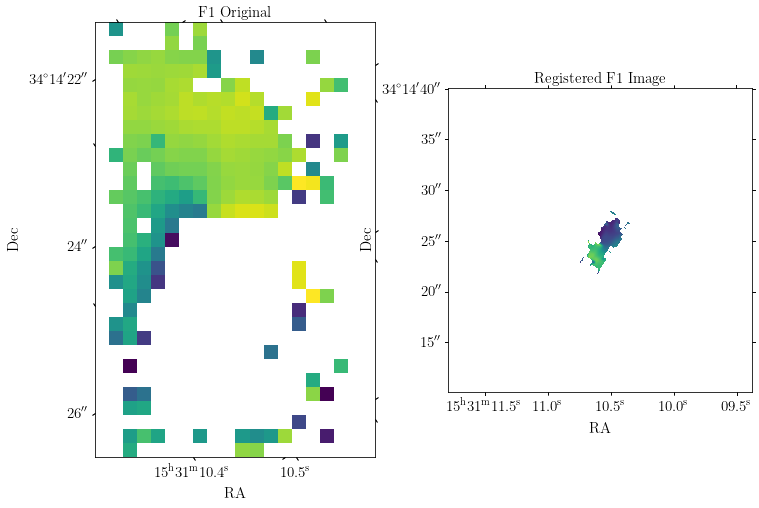

Successfully reprojected /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M1.fits to /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/gmosBeads/products/Halpha_vel_map.fits
saving new header to products folder
alma_halpha_fwhm_map.fits


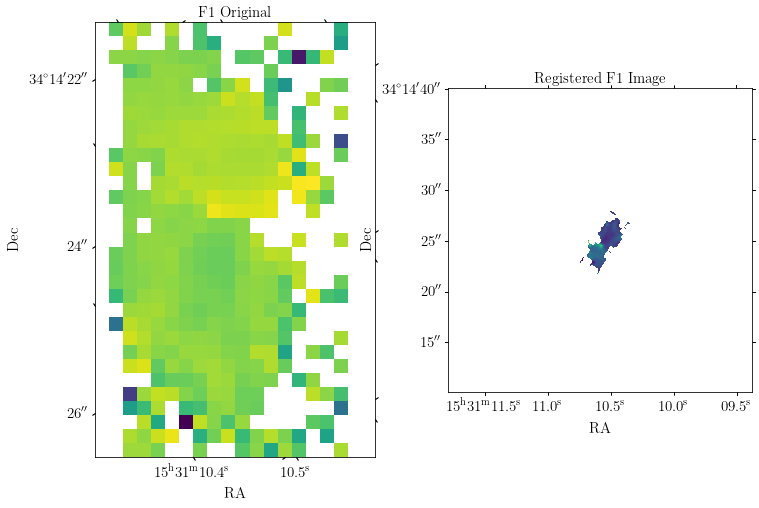

Successfully reprojected /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/almaBeads/reduced_2022/SDSS1531_CO32_20kms_natural_notaper.image.pbcor_M1.fits to /Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Analysis/gmosBeads/products/Halpha_fwhm_map.fits
saving new header to products folder


In [21]:
#reproject gmos to ALMA
ha_hdu = fits.PrimaryHDU(data=Ha_flux, header=hdr)
ha_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/Halpha_flux_map.fits"))
ha_hdu.writeto(ha_file, overwrite=True)

hav_hdu = fits.PrimaryHDU(data=ha_vel_map, header=hdr)
hav_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/Halpha_vel_map.fits"))
hav_hdu.writeto(hav_file, overwrite=True)

havd_hdu = fits.PrimaryHDU(data=ha_fwhm_map, header=hdr)
havd_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/Halpha_fwhm_map.fits"))
havd_hdu.writeto(havd_file, overwrite=True)

savepath = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/"))
gh_data, gh_hdr, gh_file = pf.reproject(ha_file, moment1_file, save_path=savepath, name = 'alma_halpha_flux_map.fits')
ghv_data, ghv_hdr, ghv_file = pf.reproject(hav_file, moment1_file, save_path=savepath, name = 'alma_halpha_vel_map.fits')
ghvd_data, ghvd_hdr, ghvd_file = pf.reproject(havd_file, moment1_file, save_path=savepath, name = 'alma_halpha_fwhm_map.fits')

In [27]:
ha_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/reprojected_alma_halpha_flux_map.fits"))
hav_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/reprojected_alma_halpha_vel_map.fits"))
havd_file = ''.join((path_to_beads, "Analysis/gmosBeads/products/reprojected/reprojected_alma_halpha_fwhm_map.fits"))

gh_hdu, gh_hdr, gh_wcs = pf.open_fits(ha_file)
ghv_hdu, ghv_hdr, ghv_wcs = pf.open_fits(hav_file)
ghvd_hdu, ghvd_hdr, ghvd_wcs = pf.open_fits(havd_file)

In [28]:
new_savepath = ''.join((path_to_beads, "Analysis/gmosBeads/products/"))
co_ha_velocity_difference = (ghv_hdu.data+300) - moment1_hdu.data/1e3 
fits.writeto(''.join((new_savepath, 'co_ha_velocity_difference.fits')), 
                        co_ha_velocity_difference, moment1_hdr, overwrite=True)
    

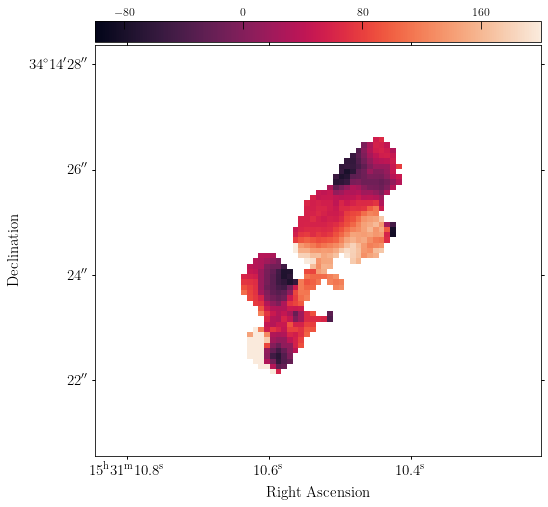

In [29]:
#draw
fig = plt.figure(figsize=(8,8))
gs1 = GridSpec(1, 1)
gs1.update(wspace=0.01)

hst_zoom = [sf.sdss1531_dict['ra'] + 2e-4, sf.sdss1531_dict['dec']-3e-4, 4 * u.arcsec]

cmap=sns.color_palette("rocket", as_cmap=True)
#ax1
ax1 = fig.add_subplot(gs1[0], projection=m1wcs)

ax1, cb1 = pf.ax_fits_map(hdu=None, data=co_ha_velocity_difference,
                         hdr=moment1_hdr, vmin=-100, vmax=200, 
                         cmap=cmap, coords=hst_zoom, ax=ax1, contour=False)

In [36]:
co_ha_dispersion_ratio = (ghvd_hdu.data)/(moment2_hdu.data/1e3)
fits.writeto(''.join((new_savepath, 'co_ha_dispersion_ratio.fits')), 
                        co_ha_dispersion_ratio , moment1_hdr, overwrite=True)

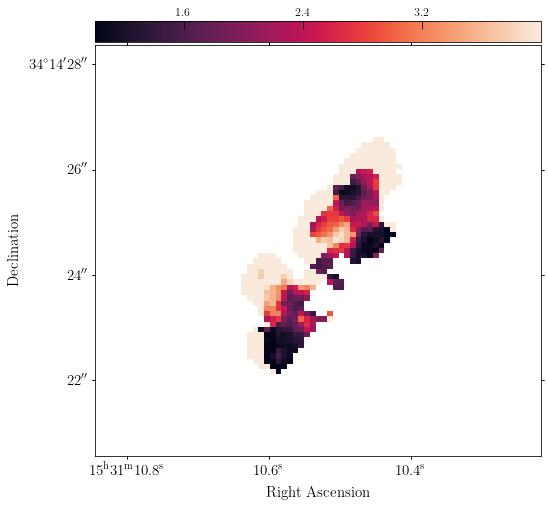

In [48]:
#draw
fig = plt.figure(figsize=(8,8))
gs1 = GridSpec(1, 1)
gs1.update(wspace=0.01)

hst_zoom = [sf.sdss1531_dict['ra'] + 2e-4, sf.sdss1531_dict['dec']-3e-4, 4 * u.arcsec]

cmap=sns.color_palette("rocket", as_cmap=True)
#ax1
ax1 = fig.add_subplot(gs1[0], projection=m1wcs)

ax1, cb1 = pf.ax_fits_map(hdu=None, data=co_ha_dispersion_ratio,
                         hdr=moment1_hdr, vmin=1, vmax=4, 
                         cmap=cmap, coords=hst_zoom, ax=ax1, contour=False)

In [49]:
np.nanmedian(co_ha_dispersion_ratio)

3.0367316145241707